# Evaluating Model Performance for Numerical Data

### Excercise: Comparing Model Performance
Load a dataset of choice, ameanible to linear regression analysis. You can use the data from the last workshop. Split the data into train - validation - and test. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_1605/2298807205.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/clean_tree_data.csv')
print(df.columns)
df.drop('Unnamed: 0', axis=1, inplace=True)


Index(['Unnamed: 0', 'growth_ground', 'diameter', 'tree_height_fixed',
       'tree_height_random', 'tree_admin', 'tree_municipality', 'age',
       'species', 'species_group', 'tree_treatment', 'Naam_buurt', 'Naam_wijk',
       'parked_cars_in_neighbourhood'],
      dtype='object')


In [3]:
# categorical variables
categorical_vars = ['growth_ground', 'tree_admin', 'tree_municipality',
                    'species', 'species_group', 'tree_treatment', 'Naam_buurt',
                    'Naam_wijk']

# I want to store the dummies for particular variables so I can include/exclude 
# them in my regression
indexed_dummy_columns = dict()

df_dummies = df.drop(categorical_vars, axis=1)

for category in categorical_vars:
    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    indexed_dummy_columns[category] = dummies.columns
    df_dummies = pd.concat([df_dummies, dummies], axis=1)

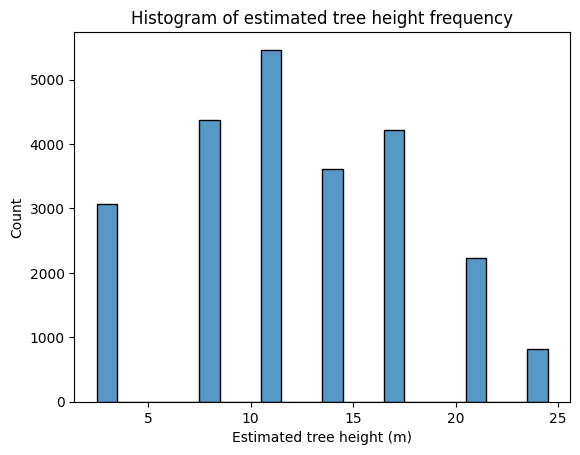

mean tree height: 11.946133467894537


In [4]:
# tree height distribution
ax = sns.histplot(df_dummies['tree_height_fixed'], discrete=True).set(
    title="Histogram of estimated tree height frequency"
)
plt.xlabel('Estimated tree height (m)')
plt.show()
print(f'mean tree height: {df_dummies['tree_height_fixed'].mean()}')

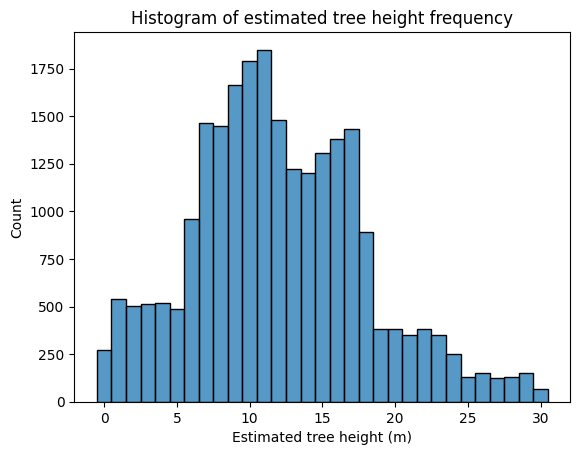

12.049939028827147

In [5]:
ax = sns.histplot(df_dummies['tree_height_random'], discrete=True).set(
    title="Histogram of estimated tree height frequency"
)
plt.xlabel('Estimated tree height (m)')
plt.show()
df_dummies['tree_height_random'].mean()

### 1a: Split your dataset into three parts, namely training, validation and test. 

In [6]:
def get_sets(df, y_variable, train_size=0.5, valid_size=0.25):
    shuffled_data = df.sample(frac=1, random_state=31415)

    total_size = len(shuffled_data.index)
    train_size = int(total_size * train_size)
    validation_size = int(total_size * valid_size)

    train_set = shuffled_data.iloc[:train_size]
    validate_set = shuffled_data.iloc[train_size:(train_size + validation_size)]
    test_set = shuffled_data.iloc[(train_size + validation_size):]

    X_train = train_set.drop(y_variable, axis=1)
    y_train = train_set[y_variable]
    X_train_full = sm.add_constant(X_train)

    X_valid = validate_set.drop(y_variable, axis=1)
    y_valid = validate_set[y_variable]
    X_valid_full = sm.add_constant(X_valid)

    X_test = test_set.drop(y_variable, axis=1)
    y_test = test_set[y_variable]
    X_test_full = sm.add_constant(X_valid)

    return {
        'X_train_full': X_train_full, 
        'y_train': y_train, 
        'X_valid_full': X_valid_full, 
        'y_valid': y_valid, 
        'X_test_full': X_test_full, 
        'y_test': y_test
    }

In [7]:
# want to see if there's a difference in the RMSE of either
sample_size = 10000
df_sample = df_dummies.sample(sample_size, random_state=31415)

df_fixed = df_sample.drop('tree_height_random', axis=1)
df_random = df_sample.drop('tree_height_fixed', axis=1)

split_fixed = get_sets(
    df_fixed,
    y_variable='tree_height_fixed'
)
split_random = get_sets(
    df_random,
    y_variable='tree_height_random'
)

### 1b:  Compare 3 models on their performance on the validation set

Define 3 models, one `unsaturated` which uses only the intercept; one `fully saturated` which represents the most complex model you can generate, and one in between. Fit each model to the training data, and generate predictions for each model on the test_set. 

In [8]:

def fit_predict_evaluate(X_train, y_train, X_valid, y_valid, credibility_pct=95, n_sims = 10000):
    
    # Fit the model
    model = sm.OLS(y_train, X_train).fit()
    
    # Step 2: Predict new values
    new_predictions = model.predict(X_valid)
    
    # Step 3: Calculate standard errors of the predictions on the validation set
    cov_matrix = model.cov_params()
    design_matrix = X_valid
    variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
    std_errors_predictions = np.sqrt(variances)
    
    # Generate posterior samples
    new_predictions_array = np.array(new_predictions)[:, None]  
    std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
    predicted_samples = np.random.normal(loc=new_predictions_array,
                                         scale=std_errors_predictions_array,
                                         size=(len(new_predictions), n_sims))
    
    # Calculate estimates summaries
    monte_carlo_medians = np.median(predicted_samples, axis=1)
    prediction_intervals = np.percentile(predicted_samples, [(100-credibility_pct)/2, credibility_pct+(100-credibility_pct)/2], axis=1)
    
    # Calculate metrics
    bias = np.mean(monte_carlo_medians - y_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, monte_carlo_medians))
    correlation = np.corrcoef(y_valid, monte_carlo_medians)[0, 1]
    coverage = np.mean((y_valid >=  prediction_intervals[0,:]) & (y_valid <=  prediction_intervals[1,:]))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': new_predictions,
        'prediction_intervals': prediction_intervals
    }

    return results

In [9]:
score_intercept_fixed = fit_predict_evaluate(
    split_fixed['X_train_full'][['const']],
    split_fixed['y_train'],
    split_fixed['X_valid_full'][['const']],
    split_fixed['y_valid'],
    credibility_pct=95
)

In [10]:
score_intercept_random = fit_predict_evaluate(
    split_random['X_train_full'][['const']],
    split_random['y_train'],
    split_random['X_valid_full'][['const']],
    split_random['y_valid'],
    credibility_pct=95
)

In [11]:
# We have a lot of variables that are just "is in specific neighbourhood"
# and that's harder to interpret. Let's try without those
variables_of_interest = [
    'age',
    'const',
    'parked_cars_in_neighbourhood',
]

categories_of_interest = [
    'growth_ground',
    'species',
    'tree_treatment',
    'tree_admin',
]

for category in categories_of_interest:
    for variable in indexed_dummy_columns[category]:
        variables_of_interest.append(variable)

score_applicable_fixed = fit_predict_evaluate(
    split_fixed['X_train_full'][variables_of_interest],
    split_fixed['y_train'],
    split_fixed['X_valid_full'][variables_of_interest],
    split_fixed['y_valid'],
    credibility_pct=95
)



In [12]:
score_applicable_random = fit_predict_evaluate(
    split_random['X_train_full'][variables_of_interest],
    split_random['y_train'],
    split_random['X_valid_full'][variables_of_interest],
    split_random['y_valid'],
    credibility_pct=95
)

In [13]:
score_saturated_fixed = fit_predict_evaluate(
    split_fixed['X_train_full'],
    split_fixed['y_train'],
    split_fixed['X_valid_full'],
    split_fixed['y_valid'],
    credibility_pct=95
)

In [14]:
score_saturated_random = fit_predict_evaluate(
    split_random['X_train_full'],
    split_random['y_train'],
    split_random['X_valid_full'],
    split_random['y_valid'],
    credibility_pct=95
)

In [15]:
# generate a table with the scores 
scores = [
    {'name': 'Intercept Only, fixed height value', **score_intercept_fixed},
    {'name': 'Interpretable features, fixed height value', **score_applicable_fixed},
    {'name': 'Saturated, fixed height value', **score_saturated_fixed},
    {'name': 'Intercept Only, random height value', **score_intercept_random},
    {'name': 'Interpretable features, random height value', **score_applicable_random},
    {'name': 'Saturated, random height value', **score_saturated_random},
]

# Convert the list of dictionaries to a DataFrame
scores_df_automated = pd.DataFrame(scores)

# Rename the 'name' column to 'Score Type' for clarity
scores_df_automated.rename(columns={'name': 'Score Type'}, inplace=True)

scores_df_automated

,Score Type,bias,rmse,correlation,coverage,predictions,prediction_intervals
0,"Intercept Only, fixed height value",0.068989,5.706830,-0.005764,0.0000,518 12.0288 17200 12.0288 7748 12....,"[[11.872948758309839, 11.878162822808637, 11.8..."
1,"Interpretable features, fixed height value",0.008694,3.364521,0.808231,0.3192,518 12.385258 17200 5.863636 7748 ...,"[[11.265945037436076, 4.5950952901668645, 11.4..."
2,"Saturated, fixed height value",-0.013403,2.966596,0.854673,0.4044,518 12.730249 17200 5.863636 7748 ...,"[[11.618739653184525, 4.752501927830294, 8.744..."
3,"Intercept Only, random height value",0.061514,6.085580,-0.008817,0.0164,518 12.111126 17200 12.111126 7748 ...,"[[11.942140071933459, 11.94463801956605, 11.94..."
4,"Interpretable features, random height value",0.008230,3.658304,0.799475,0.3188,518 12.439126 17200 5.597722 7748 ...,"[[11.210426528319868, 4.142310837746754, 11.24..."
5,"Saturated, random height value",-0.016986,3.274367,0.843268,0.4140,518 12.813908 17200 5.597722 7748 ...,"[[11.561498264438136, 4.364144288865885, 8.056..."


### 1c:  Comment on the scores

Can you identify a model to move forward with ? on what grounds ? 
What do the differences in performance over the different metrics tell you about each model's strengths and weaknesses ? 

1) All models have good correlation values and very low bias. However, this is also accompanied by poor coverage and a high RMSE. This means our predictor values predict an increase in height very consistently, but do very little to explain the variance (example: "we would expect older trees to be taller than younger trees, but we don't know why two trees of the same age can have different heights").

2) I was wondering if the RMSE has something to do with the way I calculated tree height. Height in the raw data is given in values such as "between 6 and 9", in the fixed height set, the average of the two values is used (i.e. 7.5), in the random height set, a random value between 6 and 9 is assigned. I expected the fixed height set to have higher variance (after all, predicted height would never fall "exactly on the calculated values" and always be off just because of that), however, the random set has more variance. This actually makes sense: by randomising values a bit, I'm introducing a bit more unexplained variance, so we would expect RMSE to go up! 

3) The best performing models include all the data. However, it could be very difficult to determine why there is a relationship between growing in a neighbourhood and tree height. Additionally, the better coverage tells us that we can more accurately pin-point the actual height of a tree depending on its neighbourhood - but the RMSE stays this same, which means neighbourhoods do little to explain tree height variance. This might be in fact unexplainable variance, at least with just municipal data (trees are complex, chaotic systems after all, their heights may just have genetic or inherent variance). I will use the "applicable fixed height" model because it is more explainable even if it's not the best performing one.

### 1d: For your best performning model, estimate the generalisation error 

Generate point-estimates and a measure of uncertainty for each error metric. Hint: the most comprehensive way to do this is to generate error distributions. You can do this by calculating each error metric on a separate set of simulated predictions from the empirical predictive posterior distribution. 

In [16]:
# Fit the model (best performing was National on the RMSE metric)
model = sm.OLS(
    split_fixed['y_train'], 
    split_fixed['X_train_full'][variables_of_interest]
).fit()
    
# Step 2: Predict new values
new_predictions = model.predict(split_fixed['X_valid_full'][variables_of_interest])
    
# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = split_fixed['X_valid_full'][variables_of_interest]
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)
    
# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  
std_errors_predictions_array = np.array(std_errors_predictions)[:, None] 

predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000)) 

In [17]:
# Calculate metrics
bias_array = np.mean(predicted_samples - split_fixed['y_valid'].values[:,None], axis=0)
rmse_array = np.sqrt(np.mean((predicted_samples - split_fixed['y_valid'].values[:,None])**2, axis=0))
correlation_array = np.array([np.corrcoef(split_fixed['y_valid'].values[:,None], pred, rowvar=False)[0, 1] for pred in predicted_samples.T])
# Note: coverage doesn't have a distribution, because it is already a measure which is averaged over simulations. So it is omitted here - we know it from the table above. 
# Combine metrics into a single array where each metric is a column
metrics = {
    'Bias': bias_array,
    'RMSE': rmse_array,
    'Correlation': correlation_array
}


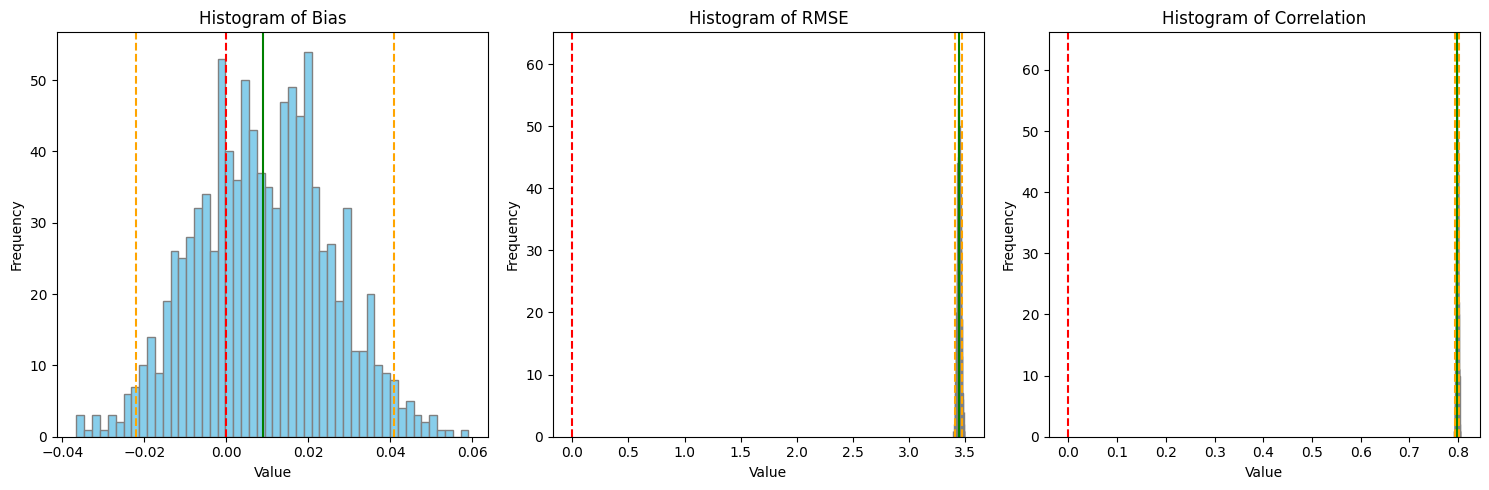

In [18]:
# plot the distributions of each error metric
import matplotlib.pyplot as plt

# Define metric names
metric_names = ['Bias', 'RMSE', 'Correlation']

# Define number of metrics to plot
n_metrics = len(metric_names)

# Adjust rows and columns calculation to avoid empty subplots
n_plots = n_metrics  # Total number of plots needed
n_rows = 1
n_cols = (n_plots + n_rows - 1) // n_rows  # Calculate columns needed, ensuring we have enough space

# Adjust the figsize if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)  # Make sure axes is always a 2D array

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, name in enumerate(metric_names):
    data = metrics[name]  # Access data directly from dictionary
    median_val = np.median(data)
    confidence_interval = np.percentile(data, [2.5, 97.5])
    
    ax = axes_flat[i]
    ax.hist(data, bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero line')  # Highlight 0 with a line
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Ensure plot encompasses 0 by adjusting xlim if necessary
    xlims = ax.get_xlim()
    ax.set_xlim(min(xlims[0], 0), max(xlims[1], 0))

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes_flat[j])

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()